In [ ]:
try:
 import art
except ModuleNotFoundError:
 !pip install adversarial-robustness-toolbox # module doesn't exist, deal with it.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

print(tf.__version__)


2.8.2


In [ ]:
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# cifar10
from tensorflow.keras import datasets, layers, models

In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
# Load the image
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
#train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
train_images, test_images = tf.cast(train_images, tf.float32), tf.cast(test_images, tf.float32)

In [ ]:
train_images = tf.keras.applications.resnet_v2.preprocess_input(train_images)
test_images = tf.keras.applications.resnet_v2.preprocess_input(test_images)

In [ ]:
def create_model():
  # Initialize the ResNet50 model, without fully-connected layers
  model = ResNet50V2(include_top=False , weights='imagenet', input_shape=(32, 32, 3), pooling='max')

  model.trainable = False

  inputs = keras.Input(shape=(32, 32, 3))

  x = model(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(128)(x)

  # A Dense classifier with a single unit (binary classification)
  outputs = keras.layers.Dense(10)(x)
  model = keras.Model(inputs, outputs)  

  return model


In [ ]:
with strategy.scope():
  model = create_model()
  model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

batch_size = 1024
steps_per_epoch = 50000 // batch_size
validation_steps = 10000 // batch_size

history = model.fit(train_images, train_labels, epochs=1000, steps_per_epoch=steps_per_epoch, 
                    validation_data=(test_images, test_labels), validation_steps=validation_steps, verbose=1)

Epoch 1/1000
48/48 [==============================] - 23s 272ms/step - loss: 1.9929 - accuracy: 0.3189 - val_loss: 1.8429 - val_accuracy: 0.3830
Epoch 2/1000
48/48 [==============================] - 2s 46ms/step - loss: 1.7714 - accuracy: 0.3959 - val_loss: 1.7832 - val_accuracy: 0.3960
Epoch 3/1000
48/48 [==============================] - 2s 44ms/step - loss: 1.7022 - accuracy: 0.4160 - val_loss: 1.7609 - val_accuracy: 0.4045
Epoch 4/1000
48/48 [==============================] - 2s 44ms/step - loss: 1.6627 - accuracy: 0.4248 - val_loss: 1.7517 - val_accuracy: 0.4069
Epoch 5/1000
48/48 [==============================] - 2s 44ms/step - loss: 1.6361 - accuracy: 0.4327 - val_loss: 1.7558 - val_accuracy: 0.4028
Epoch 6/1000
48/48 [==============================] - 3s 53ms/step - loss: 1.6168 - accuracy: 0.4384 - val_loss: 1.7496 - val_accuracy: 0.4096
Epoch 7/1000
48/48 [==============================] - 2s 43ms/step - loss: 1.6011 - accuracy: 0.4425 - val_loss: 1.7588 - val_accuracy: 0.40

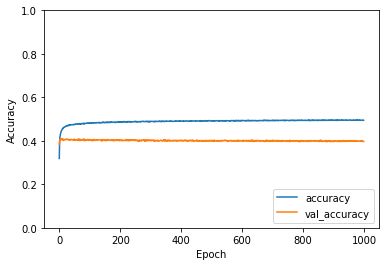

313/313 - 8s - loss: 2.3124 - accuracy: 0.3968 - 8s/epoch - 26ms/step


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

##  2   Save model

### 2.1 h5 file

In [ ]:
model.save('/content/ResNet_V2_TransferLearning.h5')